Load data

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('application_train.csv')
data.sample()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
165083,291371,0,Cash loans,F,Y,Y,0,220500.0,270000.0,10179.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

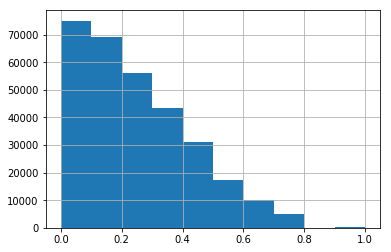

In [22]:
data['EXT_ALL'] = data['EXT_SOURCE_1'].fillna(1)*data['EXT_SOURCE_2'].fillna(1)*data['EXT_SOURCE_3'].fillna(1)
data['EXT_ALL'].hist()

In [90]:
import numpy as np

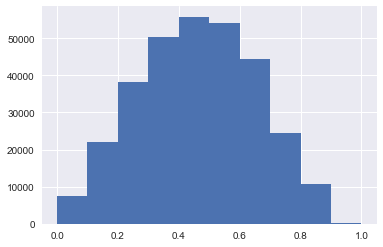

In [92]:
data['EXT_ALL_SQT'] = np.sqrt(data['EXT_ALL'])
data['EXT_ALL_SQT'].hist()

In [93]:
data.to_pickle('application_ext_all.pkl')

In [23]:
data[['TARGET','EXT_SOURCE_3', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_ALL']].corr()

,TARGET,EXT_SOURCE_3,EXT_SOURCE_1,EXT_SOURCE_2,EXT_ALL
TARGET,1.000000,-0.178919,-0.155317,-0.160472,-0.138891
EXT_SOURCE_3,-0.178919,1.000000,0.186846,0.109167,0.632391
EXT_SOURCE_1,-0.155317,0.186846,1.000000,0.213982,0.642218
EXT_SOURCE_2,-0.160472,0.109167,0.213982,1.000000,0.542502
EXT_ALL,-0.138891,0.632391,0.642218,0.542502,1.000000


In [12]:
data[data.columns[120:122]].describe()

,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,265992.000000,265992.000000
mean,0.265474,1.899974
std,0.794056,1.869295
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,0.000000,3.000000
max,261.000000,25.000000


OWN_CAR_AGE max, OBS_30_SOCIAL_CIRCLE max, DEF_30_CNT... max, OBS_60_... max, DEF_60_... max, AMT_REQ_CREDIT_BUREAU_QRT max, AMT_REQ_CREDIT_BUREAU_YEAR max

In [3]:
data.shape

(307511, 122)

In [4]:
data.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

So we have unbalanced data.  Should we be careful with different algorithms?   

## Preprocessing

It's a little painful to type (and read) the column names in UPPER CASE.  Let's make them lowercase. 

In [24]:
df = data.copy()
df = df.rename(columns=lambda x: x.lower())
df.sample()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,ext_all
182232,311215,0,Cash loans,F,N,Y,0,157500.0,1084500.0,31707.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.160212


### Imputing missing values

We know apriori that there are null values in the entries.  Let us just find out which coulms contain any null value. 

In [25]:
has_null = [col for col in df.columns 
            if sum(df[col].isnull())]

len(has_null)

67

We have to impute the missing (null) values.  However, the imputation strategy may be different based on the datatype.  Let's find which missing columns are numerical and which are categorical. 

In [26]:
has_null_num = [col for col in has_null 
                if df[col].dtype == 'float']

len(has_null_num)

61

In [27]:
has_null_cat = [col for col in has_null 
                if df[col].dtype == 'object']

len(has_null_cat)

6

Looks like `61` missing-value columns are numerical and `6` missing-value columns are categorical.  For simplicity we shall replace the missing values of a numerical column by the mean of that column.  We shall address the categorical columns individually.  Before we move on though, we whould be wary of missing values in the target column.  Let's see if there are any.  

In [28]:
'target' in has_null

False

#### Continuous

Now fill in the missing values with means.  

In [29]:
for col in has_null_num:
    df[col] = df[col].fillna(df[col].mean())

Let's check if we have any more null values.  

In [30]:
has_null_num = [col for col in df.columns 
                if (sum(df[col].isnull()) 
                    and df[col].dtype == 'float')]

len(has_null_num)

0

#### Discrete/categorical

In [31]:
has_null_cat

['name_type_suite',
 'occupation_type',
 'fondkapremont_mode',
 'housetype_mode',
 'wallsmaterial_mode',
 'emergencystate_mode']

In [32]:
df[has_null_cat].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 6 columns):
name_type_suite        306219 non-null object
occupation_type        211120 non-null object
fondkapremont_mode     97216 non-null object
housetype_mode         153214 non-null object
wallsmaterial_mode     151170 non-null object
emergencystate_mode    161756 non-null object
dtypes: object(6)
memory usage: 14.1+ MB


In [33]:
for col in has_null_cat:
    df[col] = df[col].fillna('unknown_'+col)

Let's see if there is any null entry any more.  

In [34]:
has_null = [col for col in df.columns 
            if sum(df[col].isnull())]

len(has_null)

0

### Vectorizing categorical variables

In [35]:
col_cat = [col for col in df.columns 
           
           if df[col].dtype == 'object']

In [36]:
len(col_cat)

16

In [37]:
for col in col_cat:
    dummy = pd.get_dummies(df[col], 
                           prefix=col, 
                           drop_first=True)    
    df = df.join(dummy)
    
df.shape

(307511, 253)

### Subsampling

In [38]:
df['target'].value_counts()

0    282686
1     24825
Name: target, dtype: int64

In [39]:
df_0 = df[df['target'] == 0]
df_1 = df[df['target'] == 1]
df_0.shape, df_1.shape

((282686, 253), (24825, 253))

In [40]:
df_0_sub = df_0.sample(df_1.shape[0])
df_0_sub.shape

(24825, 253)

In [41]:
df_sub = df_0_sub.append(df_1)

In [42]:
df_sub.shape

(49650, 253)

In [43]:
X = df_sub.drop(col_cat+['target'], axis=1)
y = df_sub['target']
X.shape, y.shape

((49650, 236), (49650,))

In [44]:
(y != df_sub['target']).sum()

0

In [45]:
X.sample()

,sk_id_curr,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,days_registration,...,housetype_mode_unknown_housetype_mode,wallsmaterial_mode_Mixed,wallsmaterial_mode_Monolithic,wallsmaterial_mode_Others,wallsmaterial_mode_Panel,"wallsmaterial_mode_Stone, brick",wallsmaterial_mode_Wooden,wallsmaterial_mode_unknown_wallsmaterial_mode,emergencystate_mode_Yes,emergencystate_mode_unknown_emergencystate_mode
97042,212644,1,157500.0,358213.5,28431.0,324000.0,0.01885,-10631,-1995,-4973.0,...,0,0,0,0,1,0,0,0,0,0


### Training set

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

Feature scaling seems to be detrimental to the scores.  Will skip this setp.  

In [48]:
# from sklearn.preprocessing import scale
# Xtrain = scale(Xtrain)
# Xtrain = pd.DataFrame(Xtrain)
# Xtrain.sample()

## Model training and selection

### KNN

In [49]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(Xtrain, ytrain)
ypred = knn.predict(Xtest)

Accuracy score

In [50]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)

0.5255780230403609

Confusion matrix

In [51]:
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(ytest, ypred)
con_mat

array([[4725, 1522],
       [4367, 1799]])

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

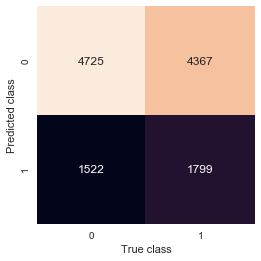

In [53]:
sns.heatmap(con_mat.T, 
            square=True, 
            annot=True, 
            fmt='d', 
            cbar=False,
            xticklabels=[0, 1], 
            yticklabels=[0, 1])

plt.xlabel('True class')
plt.ylabel('Predicted class');

Classification report

In [54]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred))

             precision    recall  f1-score   support

          0       0.52      0.76      0.62      6247
          1       0.54      0.29      0.38      6166

avg / total       0.53      0.53      0.50     12413



ROC curve score

In [55]:
from sklearn.metrics import roc_auc_score
roc_auc_score(ytest, ypred)

0.5240621628774287

### Naive Bayes

In [56]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(Xtrain, ytrain)
ypred = gnb.predict(Xtest)

Accuracy

In [57]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)

0.5822121968903569

Confusion matrix

In [58]:
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(ytest, ypred)

In [59]:
con_mat

array([[2778, 3469],
       [1717, 4449]])

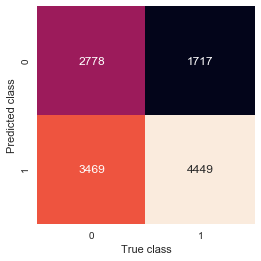

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

sns.heatmap(con_mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=[0, 1], 
           yticklabels=[0, 1])
plt.xlabel('True class')
plt.ylabel('Predicted class');

Classification report

In [61]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred))

             precision    recall  f1-score   support

          0       0.62      0.44      0.52      6247
          1       0.56      0.72      0.63      6166

avg / total       0.59      0.58      0.57     12413



ROC curve score

In [62]:
from sklearn.metrics import roc_auc_score
roc_auc_score(ytest, ypred)

0.5831154581834701

### Logistic regression

In [63]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(Xtrain, ytrain)
ypred = lr.predict(Xtest)

Accuracy

In [64]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)

0.5889792958994603

Confusion matrix

In [65]:
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(ytest, ypred)
con_mat

array([[3734, 2513],
       [2589, 3577]])

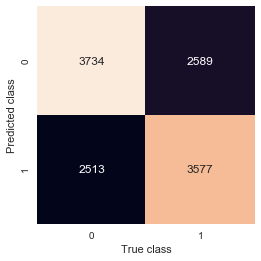

In [66]:
sns.heatmap(con_mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=[0, 1], 
           yticklabels=[0, 1])
plt.xlabel('True class')
plt.ylabel('Predicted class');

Classification report

In [67]:
print(classification_report(ytest, ypred))

             precision    recall  f1-score   support

          0       0.59      0.60      0.59      6247
          1       0.59      0.58      0.58      6166

avg / total       0.59      0.59      0.59     12413



ROC curve score

In [68]:
from sklearn.metrics import roc_auc_score
roc_auc_score(ytest, ypred)

0.5889218391483766

### Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(Xtrain, ytrain)
ypred = rf.predict(Xtest)

Accuracy

In [70]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)

0.6332876822685893

Confusion matrix

In [71]:
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(ytest, ypred)
con_mat

array([[4476, 1771],
       [2781, 3385]])

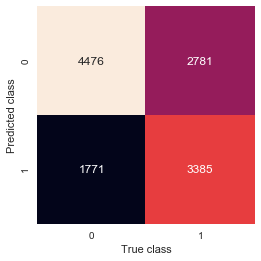

In [72]:
sns.heatmap(con_mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=[0, 1], 
           yticklabels=[0, 1])
plt.xlabel('True class')
plt.ylabel('Predicted class');

Classification report

In [73]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred))

             precision    recall  f1-score   support

          0       0.62      0.72      0.66      6247
          1       0.66      0.55      0.60      6166

avg / total       0.64      0.63      0.63     12413



ROC curve score

In [74]:
from sklearn.metrics import roc_auc_score
roc_auc_score(ytest, ypred)

0.63274109490168

#### Adaboost

In [75]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators=100)
abc.fit(Xtrain, ytrain)
ypred = abc.predict(Xtest)

Accuracy

In [76]:
accuracy_score(ytest, ypred)

0.6869411101264803

Confusion matrix

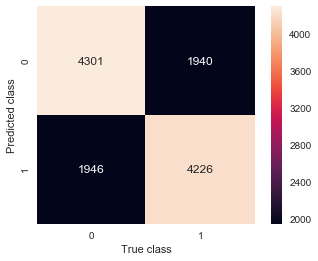

In [77]:
con_mat = confusion_matrix(ytest, ypred)
sns.heatmap(con_mat.T, 
            square=True, 
            annot=True, 
            fmt='d', 
            cbar=True,
            xticklabels=[0, 1], 
            yticklabels=[0, 1])

plt.xlabel('True class')
plt.ylabel('Predicted class')
plt.show()

Classification report

In [78]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred))

             precision    recall  f1-score   support

          0       0.69      0.69      0.69      6247
          1       0.68      0.69      0.69      6166

avg / total       0.69      0.69      0.69     12413



ROC curve score

In [79]:
roc_auc_score(ytest, ypred)

0.6869309334649947

#### GBT

In [80]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(Xtrain, ytrain)
ypred = gbc.predict(Xtest)

Accuracy

In [81]:
accuracy_score(ytest, ypred)

0.6908885845484573

Confusion matrix

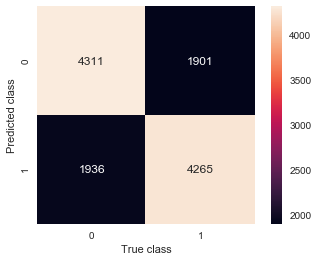

In [82]:
con_mat = confusion_matrix(ytest, ypred)

sns.heatmap(con_mat.T, 
            square=True, 
            annot=True, 
            fmt='d', 
            cbar=True,
            xticklabels=[0, 1], 
            yticklabels=[0, 1])

plt.xlabel('True class')
plt.ylabel('Predicted class');

Classification report

In [83]:
print(classification_report(ytest, ypred))

             precision    recall  f1-score   support

          0       0.69      0.69      0.69      6247
          1       0.69      0.69      0.69      6166

avg / total       0.69      0.69      0.69     12413



ROC scurve score

In [84]:
roc_auc_score(ytest, ypred)

0.6908938217038957

Feature importance

In [85]:
fi = pd.DataFrame({'variable': list(Xtrain.columns), 
                   'importance': gbc.feature_importances_})
fi = fi.sort_values(by='importance', ascending=False)
fi.tail()

,importance,variable
119,0.0,name_income_type_Maternity leave
122,0.0,name_income_type_Student
123,0.0,name_income_type_Unemployed
126,0.0,name_education_type_Incomplete higher
235,0.0,emergencystate_mode_unknown_emergencystate_mode


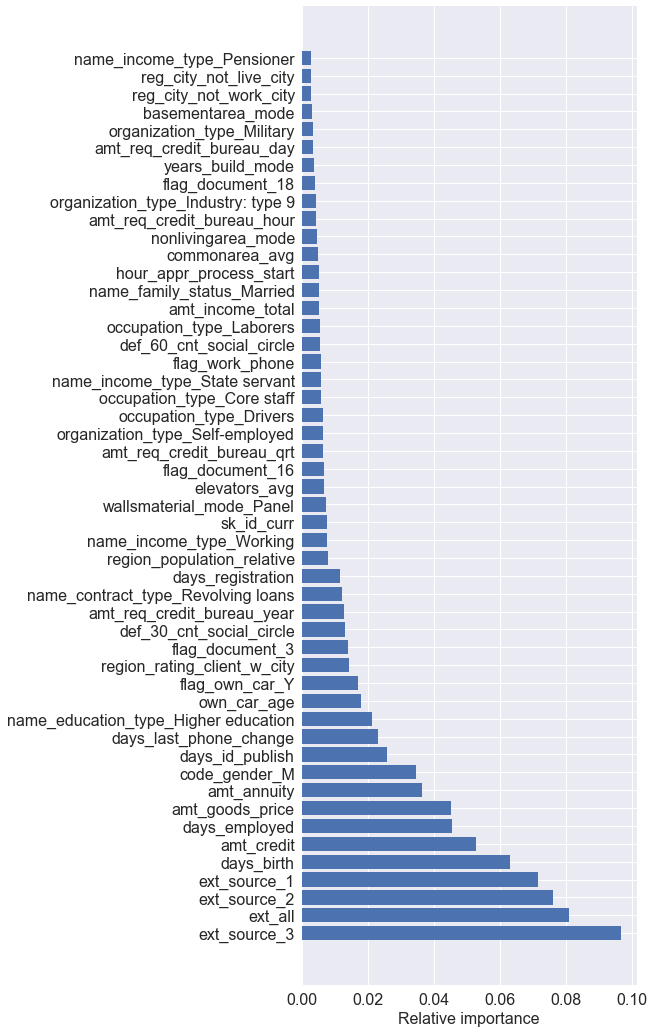

In [86]:
how_many = 50
plt.figure(figsize=(6,18))
plt.barh(range(how_many), fi['importance'].head(how_many))
plt.yticks(range(how_many), fi['variable'].head(how_many), size=16)
plt.xticks(size=16)
plt.xlabel('Relative importance', size=16)
plt.show()

## Hyperparameter tuning

In [87]:
from sklearn.model_selection import GridSearchCV

gbc = GradientBoostingClassifier()
param_grid = [{'loss': ['deviance', 'exponential']},
              {'learning_rate': [0.1, 0.2, 0.5, 1.0]},
              {'n_estimators': [100, 200]},
              {'max_depth': [1, 3, 5]}]

gs = GridSearchCV(gbc, 
                 param_grid,
                 cv=5,
                 scoring='f1')

gs.fit(Xtrain, ytrain)

KeyboardInterrupt: 

Best parameters

In [ ]:
gs.best_params_

Best estimator

In [ ]:
gs.best_estimator_

ROC score

In [ ]:
model = gs.best_estimator_
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
roc_auc_score(ytest, ypred)

In [94]:
roc_scores = [0.52, 0.57, 0.58, 0.63, 0.68]
models = ['kNN', 'Naive Bayes', 'Logistic regression', 'Random forest', 'Gradient boosted \n decision trees']
roc_scores.reverse()
models.reverse()

In [95]:
roc_scores

[0.68, 0.63, 0.58, 0.57, 0.52]

In [96]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set()

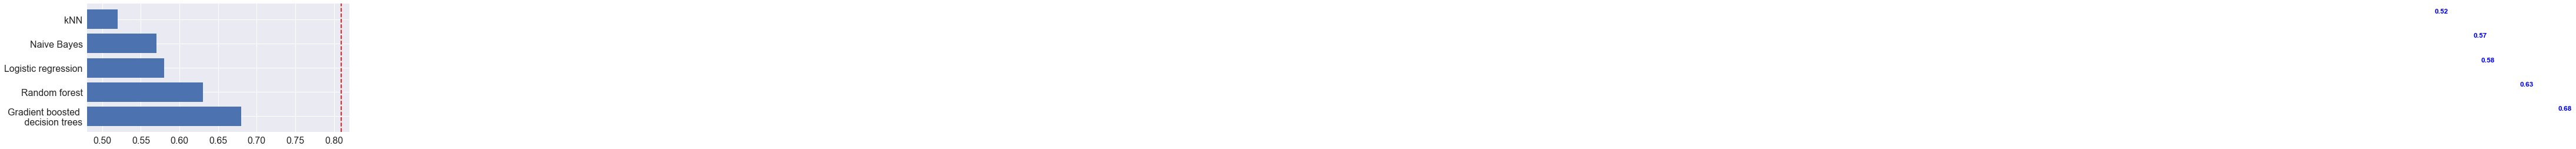

In [102]:
num_mod = len(models)
plt.figure(figsize=(8, 4))
plt.barh(range(num_mod), roc_scores, )
plt.yticks(range(num_mod), models, size=16)
plt.xticks(size=16)
plt.xlim(0.48, 0.82)
plt.axvline(x=0.809, 
            #label='Best score at Kaggle', 
            linestyle='--',
            c='r')

#plt.legend()
# plt.xlabel('Score', size=16)
plt.show();

In [ ]:
num_mod = len(models)
plt.figure(figsize=(8, 4))
plt.barh(range(num_mod), roc_scores)
plt.yticks(range(num_mod), models, size=16)
plt.xticks(size=16)
plt.xlim(0.48, 0.72)
#plt.legend()
# plt.xlabel('Score', size=16)
plt.show();

In [ ]:
import pandas as pd

In [ ]:
df_leader = pd.read_csv('home-credit-default-risk-publicleaderboard.csv')
df_leader.sample()

In [ ]:
df_leader['Score'].hist(bins=100, )
plt.xlim(0.48, 0.82)
plt.axvline(x=0.743, 
            #label='Best score at Kaggle', 
            linestyle='--',
            c='r')
plt.xticks(size=15)
plt.yticks(size=15);